In [1]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import itertools

pd.set_option('display.max_row',None)
pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('seaborn-v0_8')

# Strategy Optimizer: How to Optimize a Strategy

## Basic Approach

##### 1. Collect Backtesting Data
- **Historical Data**: Gather comprehensive historical price data for the assets you are trading.
- **Indicators**: Ensure you have the necessary indicators calculated over your historical data.
- **Trade Signals**: Identify and record trade signals based on your initial strategy parameters.

##### 2. Analyze Performance
- **Performance Metrics**: Evaluate key metrics such as profit/loss, win rate, average return, and maximum drawdown.
- **Trade Review**: Analyze individual trades to understand the context of winning and losing trades.

##### 3. Parameter Tuning
- **Parameter Range**: Define a range for each parameter of your strategy (e.g., RSI period, moving average length).
- **Optimization Methods**: Use techniques like grid search, random search, or more advanced methods such as genetic algorithms to find the best parameter combinations.
- **Avoid Overfitting**: Ensure that your parameter tuning process does not overfit the historical data by validating on out-of-sample data.

##### 4. Validate Strategy
- **Out-of-Sample Testing**: Test the optimized strategy on a separate dataset not used in the initial backtesting.
- **Walk-Forward Analysis**: Apply a walk-forward optimization to simulate real-time trading and validate robustness.

##### 5. Monitor and Adapt
- **Live Testing**: Implement the strategy in a simulated trading environment to monitor performance in real-time.
- **Regular Review**: Periodically review and adjust the strategy parameters to adapt to changing market conditions.

##### Key Considerations
- **Avoiding Overfitting**: Be cautious of overfitting, where a strategy performs exceptionally well on historical data but fails in live trading.
- **Bias Awareness**: Be aware of biases such as survivorship bias and look-ahead bias that can skew backtesting results.
- **Robustness**: Aim for strategies that perform consistently across different market conditions and time periods.

By following these steps, you can optimize your trading strategy to enhance performance while mitigating the risks of overfitting and biases.

hist = pd.read_csv('BTC-EUR.csv')
hist['Date'] = pd.to_datetime(hist['Date'])
hist = hist.set_index('Date')

In [3]:
cours = 'BTC-EUR'
actif = yf.Ticker(cours)
hist = actif.history(period="max",interval='1d')

## SMA window optimizer

### Basic Unconscious approach 

In [4]:
# Parameters to optimize
short_windows = range(5, 21)
long_windows = range(21, 51)

In [5]:
def calculate_sma(df, short_window=7, long_window=50):
    df['Short_SMA'] = df['Close'].rolling(window=short_window).mean()
    df['Long_SMA'] = df['Close'].rolling(window=long_window).mean()
    return df

def generate_sma_signals(df):
    df['Buy'] = np.where((df['Short_SMA'] > df['Long_SMA']) & (df['Short_SMA'].shift(1) <= df['Long_SMA'].shift(1)), 1, 0)
    df['Sell'] = np.where((df['Short_SMA'] < df['Long_SMA']) & (df['Short_SMA'].shift(1) >= df['Long_SMA'].shift(1)), -1, 0)
    return df


def apply_strategy(df):
    df = df.reset_index()
    # When you have the signal you buy at the price of the day after
    df['day_after'] = df['Date'].shift(-1)
    df['buy_price'] = df['Open'].shift(-1)
    
    holding = False
    trade = {}
    trades = []

    for i, row in df.iterrows():
        if row['Buy'] == 1 and not holding:
            holding = True
            trade = {
                'entry_date': row['day_after'],
                'entry_price': row['buy_price']
            }

        if holding and row['Sell'] == -1:
            holding = False
            trade['exit_date'] = row['day_after']
            trade['exit_price'] = row['buy_price']
            trades.append(trade)
            trade = {}
    return df, trades
    

# Backtesting function
def backtest_strategy(df, short_window, long_window):
    b_df = df.copy()
    b_df = calculate_sma(b_df, short_window, long_window)
    b_df = generate_sma_signals(b_df)
    _,trades = apply_strategy(b_df)
    trades = pd.DataFrame(trades)
    trades['return'] = (trades['exit_price'] - trades['entry_price']) / trades['entry_price']
    cum_return = (1 + trades['return']).prod() - 1
    return cum_return

In [6]:
backtest_strategy(hist, short_window=12, long_window=100)

114.55148530293661

In [7]:
# Optimization process
best_return = -np.inf
best_params = (None, None)
results = []

for short_window in short_windows:
    for long_window in long_windows:
        if short_window >= long_window:
            continue
        cumulative_return = backtest_strategy(hist, short_window, long_window)
        results.append((short_window, long_window, cumulative_return))
        if cumulative_return > best_return:
            best_return = cumulative_return
            best_params = (short_window, long_window)

Best Short Window: 13, Best Long Window: 38, Best Return: 621.5671290923166


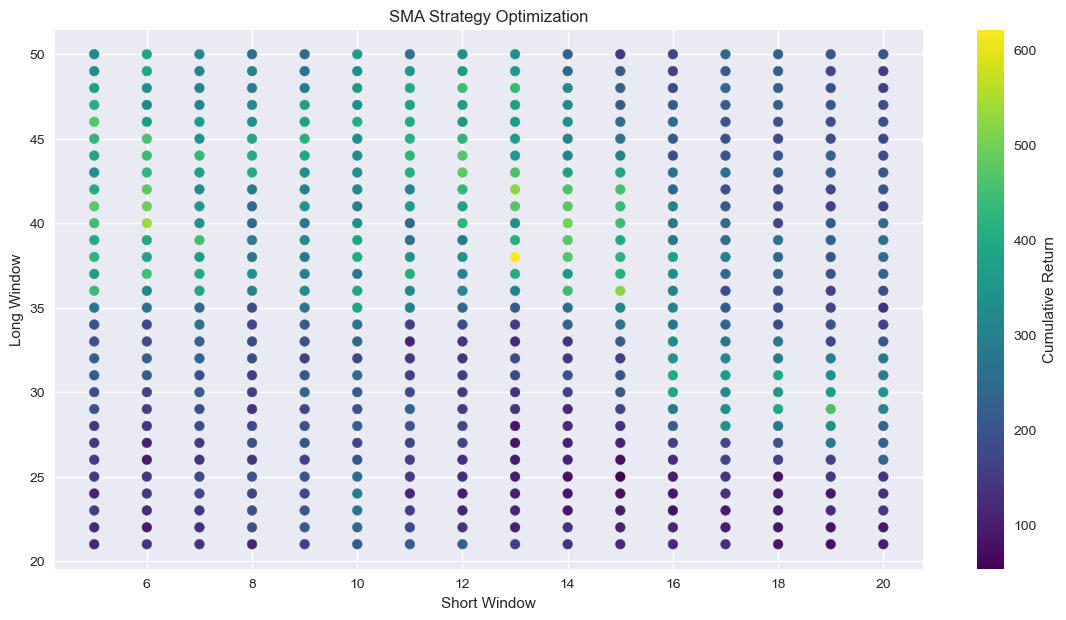

In [8]:
# Display the best parameters
print(f'Best Short Window: {best_params[0]}, Best Long Window: {best_params[1]}, Best Return: {best_return}')

# Plot results
short_windows, long_windows, cumulative_returns = zip(*results)
plt.figure(figsize=(14, 7))
plt.scatter(short_windows, long_windows, c=cumulative_returns, cmap='viridis')
plt.colorbar(label='Cumulative Return')
plt.xlabel('Short Window')
plt.ylabel('Long Window')
plt.title('SMA Strategy Optimization')
plt.show()

In [9]:
results = pd.DataFrame(results,columns=['short','long','cumret'])

In [10]:
results.sort_values(by='cumret',ascending=False).head()

,short,long,cumret
257,13,38,621.567129
49,6,40,540.358825
261,13,42,521.791257
315,15,36,521.043345
289,14,40,501.246027


### Train Test Split Approach 

In [11]:
# Split the data into training and test sets
train_size = int(len(hist) * 0.7)
train_df = hist.iloc[:train_size]
test_df = hist.iloc[train_size:]

In [12]:
short_windows = range(5, 21)
long_windows = range(21, 51) 

In [13]:
def optimize(df,short_windows,long_windows):
    # Optimization process
    best_return = -np.inf
    best_params = (None, None)
    results = []

    for short_window in short_windows:
        for long_window in long_windows:
            if short_window >= long_window:
                continue
            cumulative_return = backtest_strategy(df, short_window, long_window)
            results.append((short_window, long_window, cumulative_return))
            if cumulative_return > best_return:
                best_return = cumulative_return
                best_params = (short_window, long_window)

    return best_return, best_params,results

In [14]:
train_best_return, train_best_params, train_results  = optimize(train_df,short_windows,long_windows)

In [15]:
print(train_best_return, train_best_params)

275.8688303825267 (13, 42)


In [16]:
test_cumulative_return = backtest_strategy(test_df, train_best_params[0],train_best_params[1])

In [17]:
test_cumulative_return

0.5812856901763004

###  Walk Forward approach

In [38]:
from sklearn.model_selection import TimeSeriesSplit

In [39]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store results
train_indices = []
test_indices = []

for train_index, test_index in tscv.split(hist):
    train_indices.append(train_index)
    test_indices.append(test_index)


cumrets = []
for i in range(n_splits):
    train_best_return, train_best_params, train_results  = optimize(train_df,short_windows,long_windows)
    test_cumulative_return = backtest_strategy(test_df, train_best_params[0],train_best_params[1])



## RSI window optimizer